In [1]:
import random
import pandas as pd
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dropout, Dense
import keras as k
import keras.backend as K
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import keras

In [2]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
df = pd.read_csv('../../data/mcar_10.csv',  index_col=0)
original = pd.read_csv('../../data/original.csv',  index_col=0)
y = np.array(df['group'])
labler = LabelEncoder()
labler.fit(y)
y = labler.transform(y)

#scale the data
df2 = df.drop(['group'], axis = 1)
original = original.drop(['group'], axis = 1)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X = np.array(df2.T)  
n_dims = X.shape[1]

latent_dim = 2

In [3]:
df_t = original.T
means = np.mean(df_t, axis = 1)

In [4]:
means = np.array(means)
means.shape
print(means)

[ 9.49578408  7.02987422  7.6776426  10.57005306  8.45089206  3.26425487
  9.04994897  4.31484421  2.14830579  2.93595674  6.22265239  7.57796031
  9.30738379  8.78096901  7.61763891 13.04481847  8.73554457  3.51477523
  4.6094208   9.14279563  8.57787533  5.21618353  7.77537608  7.77528181
  4.09210512  3.02856544  5.484657    3.86193822  8.27143436  7.22858616
  8.39177839  3.75823315  1.43581251  5.6907864  13.80481667  9.51369196
  9.60897621  9.62706345  8.99341063  6.34937821  9.02721348  6.27183468
  6.61613007  7.75398161  9.22765658  7.64942744  9.15168069  4.96733142
  2.18458272  7.06121296  8.68559653  4.8343469   6.00987254  6.185844
 10.77535548  7.62645045  7.94947417  5.35131647  4.67955843  3.99394268
  7.14543623  6.14557845  2.65233002  9.53573862  5.64333203  8.17767579
  8.44612445  5.1675868   9.23435393  7.45596526  1.64267469  3.6222666
 10.59384275  5.28561083  8.02904945  7.07666458  8.22007066  5.72443182
  3.88359274  7.61041029  5.97473486  8.49721911  1.53

In [18]:
gene_y = [0 if x < 8 else 1 for x in means]

In [5]:
def masked_mae(X_true, X_pred, mask):
    masked_diff = X_true[mask] - X_pred[mask]
    return np.mean(np.abs(masked_diff))


def fill(self, missing_mask):
  self.data[missing_mask] = -1


def create_missing_mask(X):
  if X.dtype != "f" and X.dtype != "d":
      X = X.astype(float)
  return np.isnan(X.data)


def bool_to_binary(matrix):

  binary_matrix = []
  for row in matrix:
      binary_row = []
      for value in row:
          binary_row.append(1 if value else 0)
      binary_matrix.append(binary_row)
  return binary_matrix


def replace_nan(data, replacement):


  if not isinstance(data, np.ndarray):
      raise ValueError("Unsupported data type. Function supports numpy arrays only.")

  data[np.isnan(data)] = replacement

  return data


In [6]:
mask = np.array(bool_to_binary(create_missing_mask(X)))
X_no_na = replace_nan(X, replacement = 1)
input_with_mask = np.hstack([X_no_na, mask])


In [7]:
def reconstruction(input_and_mask, y_pred):
    input_and_mask = input_and_mask
    X_values = input_and_mask[:, :n_dims]

    missing_mask = input_and_mask[:, n_dims:]

    observed_mask = 1 - missing_mask

    X_values_observed = X_values * observed_mask

    pred_observed = y_pred * observed_mask

    mse = K.sum(K.square(pred_observed - X_values_observed) * K.cast(K.not_equal(X_values_observed, 0), K.floatx())) / K.maximum(K.sum(K.cast(K.not_equal(X_values_observed, 0), K.floatx())), 1)
    #mse = K.mean(K.square(X_values_observed * K.cast(K.not_equal(X_values_observed, 0), K.floatx()) - pred_observed), axis=-1)


    return mse

In [8]:
#def reconstruction(input_and_mask, y_pred):
#    mse = keras.metrics.mean_squared_error(input_and_mask, y_pred)

#    return mse

In [9]:
# This are the dimensions of the original input, the intermediate layer and latent layer
original_dim = n_dims
latent_dim = 2 # 

def sampling(args):
    # reparameterization trick
    # instead of sampling from Q(z|x), sample eps = N(0,I)
    # then x = x_mean + x_sigma*eps= x_mean + sqrt(e^(x_log_var))*eps = x_mean + e^(0.5 * x_log_var)*eps
    x_mean, x_log_var = args
    epsilon = K.random_normal(shape=(K.shape(x_mean)[0], latent_dim), mean=0.,
                              stddev=1.0)
    return x_mean + K.exp(0.5 * x_log_var) * epsilon

In [10]:
K.clear_session()

# Variational autoencoder model
input_img = keras.layers.Input(shape=(original_dim*2,))
condition = keras.layers.Input(shape = (1,))
conditional = keras.layers.Concatenate()([input_img, condition])
encoded = keras.layers.Dense(64)(conditional)
encoded = keras.layers.Dense(16)(encoded)
x_mean = keras.layers.Dense(latent_dim)(encoded)
x_log_var = keras.layers.Dense(latent_dim)(encoded) # implementation choice to encode the log variance i.s.o. the standard deviation

x = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([x_mean, x_log_var])
x = keras.layers.Concatenate()([x,condition])
# at this point the representation has dimension: latent_dim 

decoded = keras.layers.Dense(16)(x)
decoded = keras.layers.Dense(64)(decoded)
decoded = keras.layers.Dense(original_dim, activation='linear')(decoded)
vae = keras.Model([input_img,condition], decoded, name='vae')
#print (vae.summary())



2023-04-11 17:24:45.167148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# Create the loss function and compile the model
# The loss function as defined by paper Kingma

reconstruction_loss = original_dim * reconstruction(input_img, decoded)  
kl_loss =  -0.5 * K.sum(1 + x_log_var - K.square(x_mean) -K.exp(x_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Next the encoder part and decoder model, in order to inspect the inner representation, referencing the autoencode layers (the 3 models share there weights)
# This part can be ommitted in case you don't want to use the inner latent representation 

# encoder model (first part of the variotional autoencoder) 
encoder = keras.Model([input_img,condition], [x_mean, x_log_var, x], name='encoder')
#print (encoder.summary())



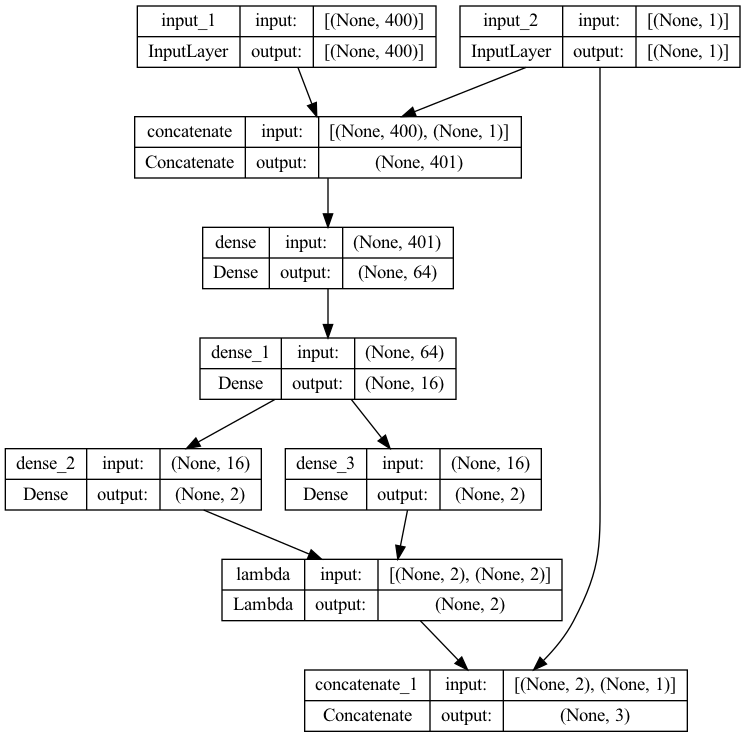

In [12]:
keras.utils.plot_model(encoder, to_file='model.png', show_shapes=True)

In [13]:
vae.fit([input_with_mask,means],input_with_mask,
        shuffle=True,
        epochs=1000,
        batch_size=32)

Epoch 1/1000
4/4 [==============================] - 0s 2ms/step - loss: 17308.1875
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 11114.8418
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 9212.9385
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 7247.0698
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 5620.9648
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 4098.5615
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 2817.4292
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 2335.0071
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 1465.4910
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 1078.8528
Epoch 11/1000
4/4 [==============================] - 0s 2ms/step - loss: 887.8375
Epoch 12/1000
4/4 [==============================] - 0s 2ms/step - loss: 734.3785
Epoch 13/1000

4/4 [==============================] - 0s 2ms/step - loss: 113.3010
Epoch 101/1000
4/4 [==============================] - 0s 2ms/step - loss: 113.7791
Epoch 102/1000
4/4 [==============================] - 0s 2ms/step - loss: 115.0181
Epoch 103/1000
4/4 [==============================] - 0s 2ms/step - loss: 113.1197
Epoch 104/1000
4/4 [==============================] - 0s 2ms/step - loss: 109.9091
Epoch 105/1000
4/4 [==============================] - 0s 2ms/step - loss: 111.0222
Epoch 106/1000
4/4 [==============================] - 0s 2ms/step - loss: 110.9616
Epoch 107/1000
4/4 [==============================] - 0s 2ms/step - loss: 107.0666
Epoch 108/1000
4/4 [==============================] - 0s 2ms/step - loss: 108.9297
Epoch 109/1000
4/4 [==============================] - 0s 2ms/step - loss: 111.4007
Epoch 110/1000
4/4 [==============================] - 0s 2ms/step - loss: 117.9668
Epoch 111/1000
4/4 [==============================] - 0s 2ms/step - loss: 107.3553
Epoch 112/1000
4/4 

4/4 [==============================] - 0s 2ms/step - loss: 84.6385
Epoch 200/1000
4/4 [==============================] - 0s 2ms/step - loss: 89.3532
Epoch 201/1000
4/4 [==============================] - 0s 2ms/step - loss: 92.8336
Epoch 202/1000
4/4 [==============================] - 0s 2ms/step - loss: 92.2158
Epoch 203/1000
4/4 [==============================] - 0s 2ms/step - loss: 88.6389
Epoch 204/1000
4/4 [==============================] - 0s 2ms/step - loss: 89.2392
Epoch 205/1000
4/4 [==============================] - 0s 2ms/step - loss: 90.4211
Epoch 206/1000
4/4 [==============================] - 0s 2ms/step - loss: 88.2064
Epoch 207/1000
4/4 [==============================] - 0s 2ms/step - loss: 85.1028
Epoch 208/1000
4/4 [==============================] - 0s 2ms/step - loss: 88.2211
Epoch 209/1000
4/4 [==============================] - 0s 2ms/step - loss: 87.5373
Epoch 210/1000
4/4 [==============================] - 0s 2ms/step - loss: 83.2561
Epoch 211/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 88.5270
Epoch 300/1000
4/4 [==============================] - 0s 2ms/step - loss: 92.4919
Epoch 301/1000
4/4 [==============================] - 0s 2ms/step - loss: 85.0994
Epoch 302/1000
4/4 [==============================] - 0s 1ms/step - loss: 84.0227
Epoch 303/1000
4/4 [==============================] - 0s 2ms/step - loss: 89.5976
Epoch 304/1000
4/4 [==============================] - 0s 2ms/step - loss: 90.1598
Epoch 305/1000
4/4 [==============================] - 0s 2ms/step - loss: 84.8259
Epoch 306/1000
4/4 [==============================] - 0s 2ms/step - loss: 81.9066
Epoch 307/1000
4/4 [==============================] - 0s 2ms/step - loss: 85.1669
Epoch 308/1000
4/4 [==============================] - 0s 2ms/step - loss: 82.9694
Epoch 309/1000
4/4 [==============================] - 0s 2ms/step - loss: 79.8413
Epoch 310/1000
4/4 [==============================] - 0s 1ms/step - loss: 79.4966
Epoch 311/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 67.4243
Epoch 400/1000
4/4 [==============================] - 0s 2ms/step - loss: 66.6932
Epoch 401/1000
4/4 [==============================] - 0s 2ms/step - loss: 69.7315
Epoch 402/1000
4/4 [==============================] - 0s 2ms/step - loss: 66.6972
Epoch 403/1000
4/4 [==============================] - 0s 2ms/step - loss: 63.3473
Epoch 404/1000
4/4 [==============================] - 0s 2ms/step - loss: 68.0995
Epoch 405/1000
4/4 [==============================] - 0s 2ms/step - loss: 64.2585
Epoch 406/1000
4/4 [==============================] - 0s 2ms/step - loss: 72.7202
Epoch 407/1000
4/4 [==============================] - 0s 1ms/step - loss: 67.9723
Epoch 408/1000
4/4 [==============================] - 0s 2ms/step - loss: 64.8446
Epoch 409/1000
4/4 [==============================] - 0s 2ms/step - loss: 66.4439
Epoch 410/1000
4/4 [==============================] - 0s 2ms/step - loss: 67.1361
Epoch 411/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 53.7359
Epoch 500/1000
4/4 [==============================] - 0s 2ms/step - loss: 57.0189
Epoch 501/1000
4/4 [==============================] - 0s 2ms/step - loss: 55.9431
Epoch 502/1000
4/4 [==============================] - 0s 2ms/step - loss: 54.2556
Epoch 503/1000
4/4 [==============================] - 0s 2ms/step - loss: 56.2900
Epoch 504/1000
4/4 [==============================] - 0s 2ms/step - loss: 57.8994
Epoch 505/1000
4/4 [==============================] - 0s 2ms/step - loss: 58.6214
Epoch 506/1000
4/4 [==============================] - 0s 2ms/step - loss: 61.1168
Epoch 507/1000
4/4 [==============================] - 0s 2ms/step - loss: 52.1736
Epoch 508/1000
4/4 [==============================] - 0s 2ms/step - loss: 52.8746
Epoch 509/1000
4/4 [==============================] - 0s 2ms/step - loss: 56.2545
Epoch 510/1000
4/4 [==============================] - 0s 2ms/step - loss: 55.2443
Epoch 511/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 42.4612
Epoch 600/1000
4/4 [==============================] - 0s 2ms/step - loss: 42.8408
Epoch 601/1000
4/4 [==============================] - 0s 2ms/step - loss: 42.7139
Epoch 602/1000
4/4 [==============================] - 0s 2ms/step - loss: 53.1795
Epoch 603/1000
4/4 [==============================] - 0s 2ms/step - loss: 47.5622
Epoch 604/1000
4/4 [==============================] - 0s 2ms/step - loss: 51.2631
Epoch 605/1000
4/4 [==============================] - 0s 2ms/step - loss: 43.0914
Epoch 606/1000
4/4 [==============================] - 0s 2ms/step - loss: 42.0105
Epoch 607/1000
4/4 [==============================] - 0s 2ms/step - loss: 45.1364
Epoch 608/1000
4/4 [==============================] - 0s 2ms/step - loss: 45.0077
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 44.2084
Epoch 610/1000
4/4 [==============================] - 0s 2ms/step - loss: 50.1756
Epoch 611/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 38.3858
Epoch 700/1000
4/4 [==============================] - 0s 2ms/step - loss: 47.2975
Epoch 701/1000
4/4 [==============================] - 0s 2ms/step - loss: 42.3498
Epoch 702/1000
4/4 [==============================] - 0s 2ms/step - loss: 50.5771
Epoch 703/1000
4/4 [==============================] - 0s 2ms/step - loss: 39.4686
Epoch 704/1000
4/4 [==============================] - 0s 2ms/step - loss: 40.1521
Epoch 705/1000
4/4 [==============================] - 0s 2ms/step - loss: 47.1538
Epoch 706/1000
4/4 [==============================] - 0s 2ms/step - loss: 37.7489
Epoch 707/1000
4/4 [==============================] - 0s 1ms/step - loss: 43.5473
Epoch 708/1000
4/4 [==============================] - 0s 2ms/step - loss: 48.4517
Epoch 709/1000
4/4 [==============================] - 0s 2ms/step - loss: 41.4329
Epoch 710/1000
4/4 [==============================] - 0s 2ms/step - loss: 38.9368
Epoch 711/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 39.9637
Epoch 800/1000
4/4 [==============================] - 0s 2ms/step - loss: 44.0854
Epoch 801/1000
4/4 [==============================] - 0s 2ms/step - loss: 45.9448
Epoch 802/1000
4/4 [==============================] - 0s 2ms/step - loss: 40.9433
Epoch 803/1000
4/4 [==============================] - 0s 2ms/step - loss: 42.7724
Epoch 804/1000
4/4 [==============================] - 0s 2ms/step - loss: 38.5124
Epoch 805/1000
4/4 [==============================] - 0s 2ms/step - loss: 39.4236
Epoch 806/1000
4/4 [==============================] - 0s 2ms/step - loss: 40.4024
Epoch 807/1000
4/4 [==============================] - 0s 2ms/step - loss: 44.4475
Epoch 808/1000
4/4 [==============================] - 0s 2ms/step - loss: 45.7440
Epoch 809/1000
4/4 [==============================] - 0s 2ms/step - loss: 44.8496
Epoch 810/1000
4/4 [==============================] - 0s 2ms/step - loss: 37.6014
Epoch 811/1000
4/4 [===========

4/4 [==============================] - 0s 2ms/step - loss: 37.0533
Epoch 900/1000
4/4 [==============================] - 0s 2ms/step - loss: 36.4279
Epoch 901/1000
4/4 [==============================] - 0s 2ms/step - loss: 35.8119
Epoch 902/1000
4/4 [==============================] - 0s 2ms/step - loss: 44.8232
Epoch 903/1000
4/4 [==============================] - 0s 2ms/step - loss: 41.6630
Epoch 904/1000
4/4 [==============================] - 0s 2ms/step - loss: 39.0278
Epoch 905/1000
4/4 [==============================] - 0s 2ms/step - loss: 34.1147
Epoch 906/1000
4/4 [==============================] - 0s 2ms/step - loss: 40.1748
Epoch 907/1000
4/4 [==============================] - 0s 2ms/step - loss: 46.8837
Epoch 908/1000
4/4 [==============================] - 0s 2ms/step - loss: 40.4587
Epoch 909/1000
4/4 [==============================] - 0s 2ms/step - loss: 38.1963
Epoch 910/1000
4/4 [==============================] - 0s 2ms/step - loss: 39.4385
Epoch 911/1000
4/4 [===========

4/4 [==============================] - 0s 1ms/step - loss: 41.3022
Epoch 1000/1000
4/4 [==============================] - 0s 2ms/step - loss: 34.6773


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Y = vae.predict([input_with_mask,means])



imputed = pd.DataFrame(Y)
scaler = StandardScaler()
z_scores = pd.DataFrame(scaler.fit_transform(imputed))
scaler2 = StandardScaler()
original2 = pd.DataFrame(scaler2.fit_transform(original.T))


# generate boolean mask for missing values
masked = df2.T.isnull()

# convert True values to index positions
missing_indexes = np.where(masked)

imputed_values = z_scores.iloc[missing_indexes].values.flatten()
orignal_values = original2.iloc[missing_indexes].values.flatten()

corr = np.corrcoef(orignal_values, imputed_values)[0, 1]
mse = np.mean((orignal_values - imputed_values) ** 2) / np.var(orignal_values)
print("Correlation coefficient:", corr)
print("Normalized Mean Squared Error:", mse)

4/4 [==============================] - 1s 1ms/step
Correlation coefficient: 0.9848123904599418
Normalized Mean Squared Error: 0.030375219102429817


4/4 [==============================] - 0s 1ms/step


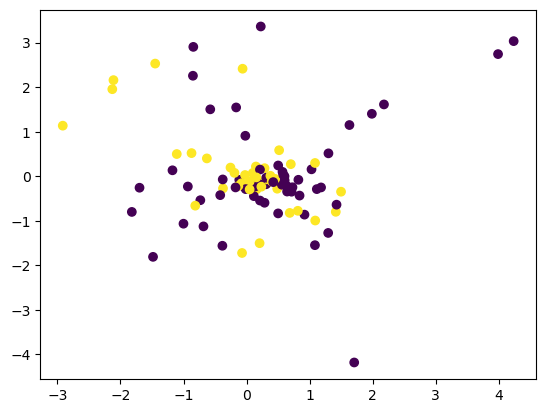

In [19]:
embedding = encoder.predict([input_with_mask,means])[0]
plt.scatter(embedding[:, 0], embedding[:, 1], c= gene_y)
plt.show()


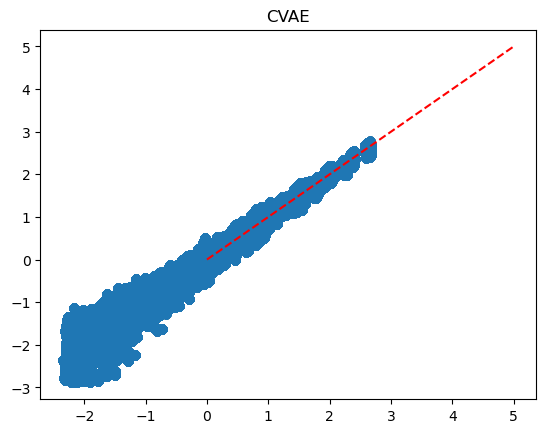

In [21]:
plt.scatter(imputed_values, orignal_values)
plt.plot([0, 5], [0, 5], color='red', linestyle='--')
plt.title('CVAE')
plt.show()

# Scaled Data

In [ ]:
# Read the Data
#df = pd.read_csv('../../data/original.csv',  index_col=0)
scaled = pd.read_csv('../../data/mcar_scaled.csv',  index_col=0)
scaled = np.array(scaled.T)  
n_dims = scaled.shape[1]

In [ ]:
mask = np.array(bool_to_binary(create_missing_mask(scaled)))
X_no_na = replace_nan(scaled, replacement = 1)
scaled_with_mask = np.hstack([X_no_na, mask])


In [ ]:
vae.fit([scaled_with_mask,means],scaled_with_mask,
        epochs=500,
        batch_size=32)

In [ ]:
embedding = encoder.predict([scaled_with_mask, means])[0]
plt.scatter(embedding[:, 0], embedding[:, 1], c=gene_y)
plt.show()